# Model Training & Selection

**Context**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

**Attribute Information**

- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

> Source: [https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [1]:
from pathlib import Path
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from enum import IntEnum, auto
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.svm import SVC
from tqdm.notebook import tqdm

RANDOM_SEED = 42

## Overview

Our Exploratory Data Analysis (EDA) revealed the following:

- The dataset is balanced and contains no missing values, eliminating the need for imputation, row deletion, or oversampling.
- We had to exclude `RestingECG`, `RestingBP`, and `Cholesterol` from our analysis as they do not contribute meaningful information for predicting heart disease.

In [2]:
df = pd.read_csv(Path.cwd() / "heart_processed.csv")
df.head()

,Age,Sex,ChestPain,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,0,172,N,0.0,Up,0
1,49,F,NAP,0,156,N,1.0,Flat,1
2,37,M,ATA,0,98,N,0.0,Up,0
3,48,F,ASY,0,108,Y,1.5,Flat,1
4,54,M,NAP,0,122,N,0.0,Up,0


Before we proceed, we need to encode our categorical features. Instead of using [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), we'll handle this process manually to ensure compatibility with our backend REST API.

In [3]:
class Sex(IntEnum):
    MALE = auto()
    FEMALE = auto()


class ChestPain(IntEnum):
    TYPICAL_ANGINA = auto()
    ATYPICAL_ANGINA = auto()
    NON_ANGINAL_PAIN = auto()
    ASYMPTOMATIC = auto()


class StSlope(IntEnum):
    UP = auto()
    FLAT = auto()
    DOWN = auto()


In [4]:
df['Sex'] = df['Sex'].map({'M': Sex.MALE, 'F': Sex.FEMALE})
df['ChestPain'] = df['ChestPain'].map({'ATA': ChestPain.ATYPICAL_ANGINA, 'NAP': ChestPain.NON_ANGINAL_PAIN, 'ASY': ChestPain.ASYMPTOMATIC, 'TA': ChestPain.TYPICAL_ANGINA})
df['ST_Slope'] = df['ST_Slope'].map({'Up': StSlope.UP, 'Flat': StSlope.FLAT, 'Down': StSlope.DOWN})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': True, 'N': False})
df.head()

,Age,Sex,ChestPain,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,2,0,172,False,0.0,1,0
1,49,2,3,0,156,False,1.0,2,1
2,37,1,2,0,98,False,0.0,1,0
3,48,2,4,0,108,True,1.5,2,1
4,54,1,3,0,122,False,0.0,1,0


## Action Plan

Based on our exploratory data analysis (EDA), we have already drawn the following conclusions:

- We will [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode our categorical features.
- Numerical features are not normally distributed and contain outliers. To address this we will employ [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).
- We will only consider models that are robust to multicollinearity. Our candidate models will be [`SVC`](https://scikit-learn.org/stable/modules/svm.html), [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [`XGBoost`](https://xgboost.readthedocs.io/en/stable/).

In [5]:
class ModelChoice(IntEnum):
    SVC = auto()
    RANDOM_FOREST = auto()
    XGB = auto()


def create_pipeline(model_choice: ModelChoice, random_state: int = RANDOM_SEED):
    target_variable = "HeartDisease"
    categorical_features = ["Sex", "ChestPain", "FastingBS", "ExerciseAngina", "ST_Slope"]
    numerical_features = list(set(df.columns).difference([target_variable, "RestingBP", "Cholesterol", *categorical_features]))

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numerical_transformer = Pipeline(steps=[
        ('scaler', RobustScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    if model_choice == ModelChoice.SVC:
        model = SVC(random_state=random_state)
    elif model_choice == ModelChoice.RANDOM_FOREST:
        model = RandomForestClassifier(random_state=random_state)
    elif model_choice == ModelChoice.XGB:
        model = XGBClassifier(random_state=random_state)
    else:
        raise ValueError("Invalid model choice")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    return pipeline


## Spiting our Dataset

Before proceeding, we need to split our dataset to ensure that our evaluation is conducted on unseen data. We’ll use the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function for this task. Specifically, we’ll allocate 80% of the data for training and reserve 20% for evaluation.

In [6]:
X, y = df.drop("HeartDisease", axis=1), df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

## Hyperparameter Tuning

We'll use [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to identify the optimal hyperparameters for our model. Unlike [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which exhaustively tests all possible hyperparameter combinations, `RandomizedSearchCV` samples from the hyperparameter space at random. This approach can be more efficient and faster, especially when dealing with a large number of hyperparameters.

In [7]:
def grid_search(
        model_choice: ModelChoice,
        X: pd.DataFrame,
        y: pd.Series,
        param_distributions: dict,
        random_state: int = RANDOM_SEED
) -> dict:
    pipeline = create_pipeline(model_choice)

    grid = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=100,
        scoring='f1',
        cv=5,
        verbose=0,
        random_state=random_state,
        n_jobs=-1
    )

    return grid.fit(X, y).best_params_

In [8]:
param_dist = {
    ModelChoice.SVC: {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', 'sigmoid'],
        'classifier__gamma': ['scale', 'auto'],
        'classifier__class_weight': [None, 'balanced']
    },
    ModelChoice.RANDOM_FOREST: {
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False]
    },
    ModelChoice.XGB: {
        'classifier__n_estimators': [100, 200, 300, 400, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'classifier__max_depth': [3, 4, 5, 6, 7, 8],
        'classifier__reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
        'classifier__reg_lambda': [0, 0.1, 0.2, 0.3, 0.4]
    }
}

best_params = {}
for model_choice in tqdm(ModelChoice):
    params = grid_search(model_choice, X_train, y_train, param_dist[model_choice])
    best_params[model_choice] = params

  0%|          | 0/3 [00:00<?, ?it/s]

/root/.cache/pypoetry/virtualenvs/heartbeat-zDt5Y6Lp-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Evaluating our Model Candidates

To assess our model candidates, we'll employ 5-fold cross-validation and evaluate their performance using accuracy, precision, recall, and F1 score.

> To this end, we'll use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).

In [9]:
metrics = ['accuracy', 'precision', 'recall', 'f1']

results = {}
for model_choice in tqdm(ModelChoice):
    model_name = model_choice.name.replace("_", " ")
    if model_choice == ModelChoice.RANDOM_FOREST:
        model_name = model_name.title()

    results[model_name] = {}
    pipeline = create_pipeline(model_choice, random_state=RANDOM_SEED)
    pipeline = pipeline.set_params(**best_params[model_choice])

    result = cross_validate(pipeline, X_train, y_train, cv=5, scoring=metrics)
    for metric in metrics:
        values = result[f'test_{metric}']
        mean = values.mean()
        std = values.std()

        results[model_name][metric.title()] = f"{mean * 100:.3f} +/- {std * 100:.3f}"

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
pd.DataFrame(results).T

,Accuracy,Precision,Recall,F1
SVC,86.918 +/- 1.480,85.830 +/- 2.698,91.269 +/- 1.139,88.427 +/- 1.053
Random Forest,86.916 +/- 2.117,85.661 +/- 3.010,91.519 +/- 1.240,88.460 +/- 1.653
XGB,86.106 +/- 2.732,85.889 +/- 2.574,89.287 +/- 2.969,87.536 +/- 2.432


In developing our heart disease prediction app, where missing a case is critical, we prioritize recall. `XGBoost` showcases the lowest recall value, so we don't consider it any further.

`RandomForestClassifier` has the highest recall, and its accuracy and F1 score are similar to those of `SVC`.

> Therefore, `RandomForestClassifier` is the best choice for our model.

## Testing our Model

In [11]:
pipeline = create_pipeline(model_choice, random_state=RANDOM_SEED)
pipeline = pipeline.set_params(**best_params[model_choice])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        77
           1       0.89      0.79      0.84       107

    accuracy                           0.82       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.83      0.82      0.82       184



Our model performs well on new data, showing a good balance across evaluation metrics. The confusion matrix below confirms this, indicating that most samples are classified correctly with only a few false negatives.

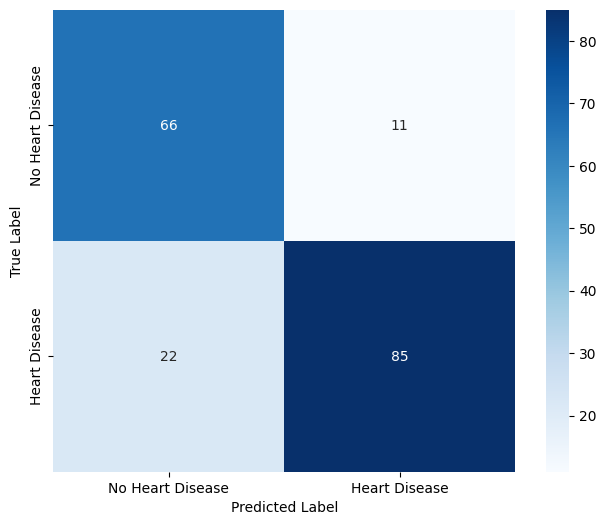

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
    cbar=True, square=True,
    xticklabels=['No Heart Disease', 'Heart Disease'],
    yticklabels=['No Heart Disease', 'Heart Disease']
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Using & Saving Our Model

Our model can be used to make predictions with the following code:

In [34]:
payload = {
    "Age": 20,
    "Sex": Sex.MALE,
    "ChestPain": ChestPain.ASYMPTOMATIC,
    "FastingBS": True,
    "MaxHR": 60,
    "ExerciseAngina": True,
    "Oldpeak": 0.0,
    "ST_Slope": StSlope.DOWN,
}

pipeline.predict(pd.DataFrame([payload]))[0]

np.int64(1)

We use [`joblib`](https://scikit-learn.org/stable/modules/model_persistence.html) to save our model for future use in our application.

In [35]:
joblib.dump(pipeline, Path.cwd() / "model.joblib")

['/mnt/c/Users/bills/Desktop/heartbeat/src/notebooks/model.joblib']